# Ranking RPLAN using a visually-guided graph edit distance

This notebooks explains how to use the ranking algorithm. First, we set the path:

In [1]:
import os
from constants import DATA_PATH

print(os.path.exists(DATA_PATH))

True


Next, we load the IDs of the RPLAN dataset:

In [3]:
from utils import gather_ids

# gather IDs
ids = gather_ids(r'./data/valid_ids.pickle', shuffle=True)  # these are default setting (just to show you)

# print first 20 IDs
print(ids[:20])

[63586, 57205, 62420, 23273, 8472, 64219, 18367, 21313, 76160, 79936, 45206, 59448, 6462, 72511, 65347, 17697, 78713, 75931, 19738, 7532]


Let's pick a random ID from that list: 57205. And plot it:

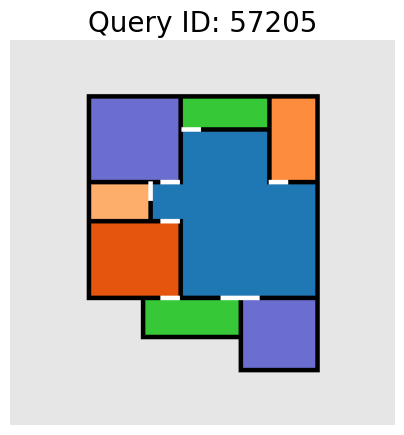

In [25]:
from utils import load_image_rplan, colorize_floorplan
from constants import CLASSES, CMAP_ROOMTYPE
from plot import set_figure

# set up figure
fs = 5  # figure size
n = 5  # number of columns (same as rows)
_, ax = set_figure(nc=1, nr=1, fs=fs, fs_title=4)  # sets the figure

id_q = 57205

# load and colorize floor plan image
img_q = load_image_rplan(id_q, DATA_PATH)
img = colorize_floorplan(img_q, CLASSES, CMAP_ROOMTYPE)

# plot image
ax.imshow(img)
ax.set_title(f'Query ID: {id_q}')
_ = ax.axis('off')

In [29]:
import numpy as np

def compute_iou(img_q, img_k, classes=np.arange(0, 12)):

    """
    Computes the Intersection-over-Union, or Jaccard Distance, between two semantic images.
    Inputs: query and key image; should be 2-D numpy arrays of the same shape.
    """

    iou_class = []

    # compute iou per class
    for cat in classes:

        # compute union
        union_area = (img_k == cat)

        if union_area.sum() == 0:
            iou_class.append(np.nan)

        else:
            union_area += (img_q == cat)
            # compute intersection
            inter_area = (img_q - img_k) == 0
            inter_area = inter_area * union_area

            iou_class.append(np.sum(inter_area) / np.sum(union_area))

    return np.nanmean(iou_class)


# IoU between query image and a list or array of images
# def get_ious(img_q, imgs, background=False):
#     """
#     Intersection-over-union between query and stack of key images.
#     """
#
#     # Initialize IoU vector
#     n = imgs.shape[0]
#     ious = np.zeros((n))
#
#     # Compute IoU across full set of images
#     for i in range(n):
#         img_k = imgs[i]
#         ious[i] = compute_iou(img_q, img_k, background=background)
#
#     return ious

## MIoU rank

We rank the remaining part of the dataset w.r.t. the above-defined floor plan.

First, we create a stack of images by loading them all in a list.

In [20]:
import torch
from tqdm.auto import tqdm

# set query image to pytorch tensor
img_q = torch.tensor(img_q)

# sort ID list
ids = sorted(ids)
print(ids[:20])

# create image list
imgs = []
for id in tqdm(ids):
    imgs.append(load_image_rplan(id, DATA_PATH))

[0, 1, 2, 4, 5, 7, 9, 10, 12, 15, 16, 18, 20, 21, 22, 23, 24, 26, 30, 33]


C:\Users\caspervanengel\AppData\Local\Temp\ipykernel_11560\3762389632.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_q = torch.tensor(img_q)


  0%|          | 0/46063 [00:00<?, ?it/s]

In [31]:
import numpy as np
import time

from metrics import mean_iou

# set classes to 12 (do not include background)
CLASSES = np.arange(0, 12)

# initialie iou list
ious = []

start = time.time()  # keep time
for i, id in tqdm(enumerate(ids), total=len(ids)):

    # iou_torch = mean_iou(torch.tensor(img_q), torch.tensor(imgs[i]), classes=CLASSES)
    ious.append(compute_iou(img_q, imgs[i], classes=CLASSES))

    # compute IoU and append to list
    # print(iou_torch, iou_numpy)

    # if i == 20: break

# print execution time to rank on IoU
print(f'Time it took to rank on IoU: {time.time() - start}')

  0%|          | 0/46063 [00:00<?, ?it/s]

Time it took to rank on IoU: 85.65868306159973
